Based on 'Declarative Datalog Debugging for Mere Mortals'

S. Köhler, B. Ludäscher, and Y. Smaragdakis, “Declarative datalog debugging for meremortals,” in International Datalog 2.0 Workshop. Springer, 2012, pp. 111–122.

[Slides](https://www.slideshare.net/ludaesch/declarative-datalog-debugging-for-mere-mortals) [Paper](https://yanniss.github.io/DeclarativeDebugging.pdf)

## Imports

In [1]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.visualize import PWEVisualization
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.export import PWEExport
import pandas as pd

In [2]:
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
import networkx as nx

In [3]:
%load_ext PWE_NB_Extension

## Experiment

Tracing provenance of "faulty" or "unexpected" outputs of an ASP program can be hard. To address this, Köhler et. al., proposed a method for debugging and logically profiling an ASP program by generating a provenance enriched rewriting of the program. We test their approach on a simple transitive closure query on a small instance graph.

##### Instance Graph

In [4]:
%%clingo --donot-run --donot-display_input -lci edb_instance

% Graph Instance
% graphviz graph graph_type=directed rankdir=LR

% Defining the edges
% schema e(tail, head)
% graphviz edge e(HEAD,TAIL) ord=2 style=solid
e(a,b). e(b,c). e(c,b). e(c,d).

##### Transitive Closure Query (Standard)

In [5]:
%%clingo --donot-run --donot-display_input -lci tc_rules

% Standard Transitive Closure Rules
% schema tc(tail, head)
% graphviz edge tc(HEAD, TAIL) ord=1 style=dashed
tc(X,Y) :- e(X,Y).          % r1
tc(X,Y) :- e(X,Z), tc(Z,Y). % r2

In [6]:
%%clingo -l tc_rules edb_instance --donot-display_input --save_meta_data_to std_md --saveto std_inst_out
#show tc/2.
#show e/2.

Output:


'Answer: 1\ne(a,b) e(b,c) e(c,b) e(c,d) tc(a,b) tc(b,c) tc(c,b) tc(c,d) tc(b,d) tc(b,b) tc(a,c) tc(c,c) tc(a,d)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.009s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

In [7]:
dd_pw_rel_dfs, dd_schemas, dd_pw_objs = load_worlds(std_inst_out, std_md, print_parse_tree=False, reasoner='clingo')

Number of Models: 1


In [8]:
dd_pw_rel_dfs.keys()

dict_keys(['e_2', 'tc_2'])

In [9]:
dd_pw_rel_dfs['tc_2']

,pw,tail,head
0,1,a,b
1,1,b,c
2,1,c,b
3,1,c,d
4,1,b,d
5,1,b,b
6,1,a,c
7,1,c,c
8,1,a,d


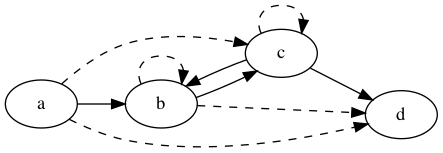

In [10]:
g = PWEVisualization.graphviz_from_meta_data(dd_pw_rel_dfs, std_md['graphviz'])
draw(g)

The dotted lines above are the transitive closure relationships (in addition to the edge relations).

#### Rewriting

We first apply the F(iring) Trick which captures rule-firings for each rule, in our case r1 and r2. Note that the 'fire' atoms contain all the existential variables, enriching the captured provenance. The heads of the original rules' heads are now just projections of these 'fire' relations.

In [11]:
%%clingo -lci f_trick_rules --donot-run --donot-display_input

% F-Trick: Capturing Rule Firings
fire1(X,Y) :- e(X,Y).  % r1_in
tc(X,Y) :- fire1(X,Y). % r1_out

fire2(X,Z,Y) :- e(X,Z), tc(Z,Y). % r2_in
tc(X,Y) :- fire2(X,Z,Y).         % r2_out

In [12]:
%%clingo -l edb_instance f_trick_rules --donot-display_input
#show tc/2.
#show fire1/2.
#show fire2/3.

Output:


'Answer: 1\nfire1(a,b) fire1(b,c) fire1(c,b) fire1(c,d) tc(a,b) tc(b,c) tc(c,b) tc(c,d) tc(c,c) tc(a,c) tc(b,b) tc(b,d) tc(a,d) fire2(b,c,d) fire2(b,c,b) fire2(a,b,c) fire2(c,b,c) fire2(a,b,d) fire2(c,b,d) fire2(a,b,b) fire2(c,b,b) fire2(b,c,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

Next, we apply the G(raph) Trick, which allows us to build a provenance graph of all the output atoms and their intermediates.

In [13]:
%%clingo -lci g_trick_rules --donot-run --donot-display_input
% G-Trick Rules

% r1
g( e(X,Y),     in,  fire1(X,Y) ) :- fire1(X,Y).
g( fire1(X,Y), out, tc(X,Y) )    :- fire1(X,Y).

% r2
g( e(X,Z),         in,  fire2(X,Z,Y) )  :- fire2(X,Z,Y).
g( tc(Z,Y),        in,  fire2(X,Z,Y) )  :- fire2(X,Z,Y).
g( fire2(X,Z,Y),   out, tc(X,Y) )       :- fire2(X,Z,Y).

In [14]:
%%clingo -l edb_instance f_trick_rules g_trick_rules --donot-display_input --saveto fg_out
#show g/3.
#show tc/2.

Output:


'Answer: 1\ntc(a,b) tc(b,c) tc(c,b) tc(c,d) tc(c,c) tc(a,c) tc(b,b) tc(b,d) tc(a,d) g(fire2(b,c,d),out,tc(b,d)) g(fire2(b,c,b),out,tc(b,b)) g(fire2(a,b,c),out,tc(a,c)) g(fire2(c,b,c),out,tc(c,c)) g(fire2(a,b,d),out,tc(a,d)) g(fire2(c,b,d),out,tc(c,d)) g(fire2(a,b,b),out,tc(a,b)) g(fire2(c,b,b),out,tc(c,b)) g(fire2(b,c,c),out,tc(b,c)) g(tc(c,d),in,fire2(b,c,d)) g(tc(c,b),in,fire2(b,c,b)) g(tc(b,c),in,fire2(a,b,c)) g(tc(b,c),in,fire2(c,b,c)) g(tc(b,d),in,fire2(a,b,d)) g(tc(b,d),in,fire2(c,b,d)) g(tc(b,b),in,fire2(a,b,b)) g(tc(b,b),in,fire2(c,b,b)) g(tc(c,c),in,fire2(b,c,c)) g(e(b,c),in,fire2(b,c,d)) g(e(b,c),in,fire2(b,c,b)) g(e(a,b),in,fire2(a,b,c)) g(e(c,b),in,fire2(c,b,c)) g(e(a,b),in,fire2(a,b,d)) g(e(c,b),in,fire2(c,b,d)) g(e(a,b),in,fire2(a,b,b)) g(e(c,b),in,fire2(c,b,b)) g(e(b,c),in,fire2(b,c,c)) g(fire1(a,b),out,tc(a,b)) g(fire1(b,c),out,tc(b,c)) g(fire1(c,b),out,tc(c,b)) g(fire1(c,d),out,tc(c,d)) g(e(a,b),in,fire1(a,b)) g(e(b,c),in,fire1(b,c)) g(e(c,b),in,fire1(c,b)) g(e(c,d),in,fire1(c,d))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [15]:
dd_pw_rel_dfs, dd_schemas, dd_pw_objs = load_worlds(fg_out, std_md, reasoner='clingo', print_parse_tree=False, internal_facts_as_string=True)


Number of Models: 1


In [16]:
dd_pw_rel_dfs.keys()

dict_keys(['tc_2', 'g_3'])

In [17]:
dd_pw_rel_dfs['g_3']

,pw,x1,x2,x3
0,1,"fire2(b,c,d)",out,"tc(b,d)"
1,1,"fire2(b,c,b)",out,"tc(b,b)"
2,1,"fire2(a,b,c)",out,"tc(a,c)"
3,1,"fire2(c,b,c)",out,"tc(c,c)"
4,1,"fire2(a,b,d)",out,"tc(a,d)"
5,1,"fire2(c,b,d)",out,"tc(c,d)"
6,1,"fire2(a,b,b)",out,"tc(a,b)"
7,1,"fire2(c,b,b)",out,"tc(c,b)"
8,1,"fire2(b,c,c)",out,"tc(b,c)"
9,1,"tc(c,d)",in,"fire2(b,c,d)"


Next, we apply the S(tatelog) Trick. This involves adding a new "state" parameter to our earlier F and G Tricks. Rather than just recording the rule firings, we now also record the time-step it was fired at. Similarly, this state information shows up in the provenance graph built using the G trick. The computation is constrained to stop when no "new" results are found.

There are two variants of the S trick, the doubly recursive version shown below:

In [18]:
%%clingo -lci fgs_trick_rules --donot-run --donot-display_input

% Doubly-Recursive

% S-Trick Rules

% temporal tc(T,_,_)
tc(X,Y) :- tc(_,X,Y).


% schema g(state, input, dir, output)
% temporal g(T,_,_,_)

% r1
% temporal fire1(T,_,_)
fire1(S1, X, Y) :- e(X, Y), next(S, S1). % r1_in
tc(S, X, Y) :- fire1(S, X, Y).           % r1_out
% g_r1
g( S, e(X,Y),     in,  fire1(X,Y) ) :- fire1(S,X,Y).
g( S, fire1(X,Y), out, tc(X,Y) )    :- fire1(S,X,Y).

% r2
% temporal fire2(T,_,_,_)
fire2(S1, X, Z, Y) :- tc(S,X,Z), tc(S,Z,Y), next(S,S1).   % r2_in
tc(S, X, Y) :- fire2(S, X, Z, Y).                         % r2_out
% g_r2
g( S, tc(X,Z),        in,  fire2(X,Z,Y) )  :- fire2(S,X,Z,Y).
g( S, tc(Z,Y),        in,  fire2(X,Z,Y) )  :- fire2(S,X,Z,Y).
g( S, fire2(X,Z,Y),   out, tc(X,Y) )       :- fire2(S,X,Z,Y).

% next
next(0,1).
next(S,S1) :- next(_,S), new(S), S1=S+1.

% new

newAtom(S1,A) :- next(S,S1), g(S1,_,out,A), not g(S,_,out,A).
newFiring(S1,F) :- next(S,S1), g(S1,F,out,_), not g(S,F,out,_).
% temporal new(T)
new(S1) :- newAtom(S1,_), S1 < 100.
% new(S1) :- newFiring(S1,_), S1 < 10.

and the Right-recursive version shown below. We will use this version for this experiment.

In [19]:
%%clingo -lci fgs_trick_rules --donot-run --donot-display_input

% Right Recursive

% S-Trick Rules

% temporal tc(T,_,_)
tc(X,Y) :- tc(_,X,Y).

% schema g(state, input, dir, output)
% temporal g(T,_,_,_)

% r1
% temporal fire1(T,_,_)
fire1(S1, X, Y) :- e(X, Y), next(S, S1). % r1_in
tc(S, X, Y) :- fire1(S, X, Y).           % r1_out
% g_r1
g( S, e(X,Y),     in,  fire1(X,Y) ) :- fire1(S,X,Y).
g( S, fire1(X,Y), out, tc(X,Y) )    :- fire1(S,X,Y).

% r2
% temporal fire2(T,_,_,_)
fire2(S1, X, Z, Y) :- e(X,Z), tc(S,Z,Y), next(S,S1).   % r2_in
tc(S, X, Y) :- fire2(S, X, Z, Y).                      % r2_out
% g_r2
g( S, e(X,Z),         in,  fire2(X,Z,Y) )  :- fire2(S,X,Z,Y).
g( S, tc(Z,Y),        in,  fire2(X,Z,Y) )  :- fire2(S,X,Z,Y).
g( S, fire2(X,Z,Y),   out, tc(X,Y) )       :- fire2(S,X,Z,Y).

% next
next(0,1).
next(S,S1) :- next(_,S), new(S), S1=S+1.

% new

newAtom(S1,A) :- next(S,S1), g(S1,_,out,A), not g(S,_,out,A).
newFiring(S1,F) :- next(S,S1), g(S1,F,out,_), not g(S,F,out,_).
% temporal new(T)
new(S1) :- newAtom(S1,_), S1 < 100.
% new(S1) :- newFiring(S1,_), S1 < 10.

In [20]:
%%clingo -l edb_instance fgs_trick_rules --donot-display_input -s fgs_out --save_meta_data_to fgs_md
#show g/4.
#show fire1/3.
#show fire2/4.
#show newAtom/2.
#show newFiring/2.
#show next/2.
#show new/1.
#show tc/2.
#show tc/3.

Output:


'Answer: 1\nnewFiring(1,fire1(c,d)) newFiring(1,fire1(c,b)) newFiring(1,fire1(b,c)) newFiring(1,fire1(a,b)) next(0,1) tc(c,d) tc(c,b) tc(b,c) tc(a,b) fire1(1,a,b) fire1(1,b,c) fire1(1,c,b) fire1(1,c,d) tc(1,c,d) tc(1,c,b) tc(1,b,c) tc(1,a,b) g(1,fire1(c,d),out,tc(c,d)) g(1,fire1(c,b),out,tc(c,b)) g(1,fire1(b,c),out,tc(b,c)) g(1,fire1(a,b),out,tc(a,b)) g(1,e(a,b),in,fire1(a,b)) g(1,e(b,c),in,fire1(b,c)) g(1,e(c,b),in,fire1(c,b)) g(1,e(c,d),in,fire1(c,d)) newAtom(1,tc(c,d)) newAtom(1,tc(c,b)) newAtom(1,tc(b,c)) newAtom(1,tc(a,b)) new(1) next(1,2) fire2(2,b,c,d) fire2(2,b,c,b) fire2(2,a,b,c) fire2(2,c,b,c) fire1(2,a,b) fire1(2,b,c) fire1(2,c,b) fire1(2,c,d) tc(2,c,c) tc(2,a,c) tc(2,b,b) tc(2,b,d) g(2,fire2(c,b,c),out,tc(c,c)) g(2,fire2(a,b,c),out,tc(a,c)) g(2,fire2(b,c,b),out,tc(b,b)) g(2,fire2(b,c,d),out,tc(b,d)) tc(2,c,d) tc(2,c,b) tc(2,b,c) tc(2,a,b) g(2,fire1(c,d),out,tc(c,d)) g(2,fire1(c,b),out,tc(c,b)) g(2,fire1(b,c),out,tc(b,c)) g(2,fire1(a,b),out,tc(a,b)) newAtom(2,tc(c,c)) newAtom(2,tc(a,c)) newAtom(2,tc(b,b)) newAtom(2,tc(b,d)) new(2) next(2,3) fire2(3,b,c,c) fire2(3,a,b,b) fire2(3,c,b,b) fire2(3,a,b,d) fire2(3,c,b,d) fire2(3,b,c,d) fire2(3,b,c,b) fire2(3,a,b,c) fire2(3,c,b,c) fire1(3,a,b) fire1(3,b,c) fire1(3,c,b) fire1(3,c,d) tc(3,c,c) tc(3,a,c) tc(3,b,b) tc(3,b,d) tc(3,c,d) tc(3,a,d) tc(3,c,b) tc(3,a,b) tc(3,b,c) g(3,fire2(c,b,c),out,tc(c,c)) g(3,fire2(a,b,c),out,tc(a,c)) g(3,fire2(b,c,b),out,tc(b,b)) g(3,fire2(b,c,d),out,tc(b,d)) g(3,fire2(c,b,d),out,tc(c,d)) g(3,fire2(a,b,d),out,tc(a,d)) g(3,fire2(c,b,b),out,tc(c,b)) g(3,fire2(a,b,b),out,tc(a,b)) g(3,fire2(b,c,c),out,tc(b,c)) g(3,fire1(c,d),out,tc(c,d)) g(3,fire1(c,b),out,tc(c,b)) g(3,fire1(b,c),out,tc(b,c)) g(3,fire1(a,b),out,tc(a,b)) newAtom(3,tc(a,d)) new(3) next(3,4) fire2(4,b,c,c) fire2(4,a,b,b) fire2(4,c,b,b) fire2(4,a,b,d) fire2(4,c,b,d) fire2(4,b,c,d) fire2(4,b,c,b) fire2(4,a,b,c) fire2(4,c,b,c) fire1(4,a,b) fire1(4,b,c) fire1(4,c,b) fire1(4,c,d) tc(4,c,c) tc(4,a,c) tc(4,b,b) tc(4,b,d) tc(4,c,d) tc(4,a,d) tc(4,c,b) tc(4,a,b) tc(4,b,c) g(4,fire2(c,b,c),out,tc(c,c)) g(4,fire2(a,b,c),out,tc(a,c)) g(4,fire2(b,c,b),out,tc(b,b)) g(4,fire2(b,c,d),out,tc(b,d)) g(4,fire2(c,b,d),out,tc(c,d)) g(4,fire2(a,b,d),out,tc(a,d)) g(4,fire2(c,b,b),out,tc(c,b)) g(4,fire2(a,b,b),out,tc(a,b)) g(4,fire2(b,c,c),out,tc(b,c)) g(4,fire1(c,d),out,tc(c,d)) g(4,fire1(c,b),out,tc(c,b)) g(4,fire1(b,c),out,tc(b,c)) g(4,fire1(a,b),out,tc(a,b)) newFiring(2,fire2(c,b,c)) newFiring(2,fire2(a,b,c)) newFiring(2,fire2(b,c,b)) newFiring(2,fire2(b,c,d)) newFiring(3,fire2(c,b,d)) newFiring(3,fire2(a,b,d)) newFiring(3,fire2(c,b,b)) newFiring(3,fire2(a,b,b)) newFiring(3,fire2(b,c,c)) g(2,tc(c,d),in,fire2(b,c,d)) g(2,tc(c,b),in,fire2(b,c,b)) g(2,tc(b,c),in,fire2(a,b,c)) g(2,tc(b,c),in,fire2(c,b,c)) g(3,tc(c,c),in,fire2(b,c,c)) g(3,tc(b,b),in,fire2(a,b,b)) g(3,tc(b,b),in,fire2(c,b,b)) g(3,tc(b,d),in,fire2(a,b,d)) g(3,tc(b,d),in,fire2(c,b,d)) g(3,tc(c,d),in,fire2(b,c,d)) g(3,tc(c,b),in,fire2(b,c,b)) g(3,tc(b,c),in,fire2(a,b,c)) g(3,tc(b,c),in,fire2(c,b,c)) g(4,tc(c,c),in,fire2(b,c,c)) g(4,tc(b,b),in,fire2(a,b,b)) g(4,tc(b,b),in,fire2(c,b,b)) g(4,tc(b,d),in,fire2(a,b,d)) g(4,tc(b,d),in,fire2(c,b,d)) g(4,tc(c,d),in,fire2(b,c,d)) g(4,tc(c,b),in,fire2(b,c,b)) g(4,tc(b,c),in,fire2(a,b,c)) g(4,tc(b,c),in,fire2(c,b,c)) g(2,e(b,c),in,fire2(b,c,d)) g(2,e(b,c),in,fire2(b,c,b)) g(2,e(a,b),in,fire2(a,b,c)) g(2,e(c,b),in,fire2(c,b,c)) g(3,e(b,c),in,fire2(b,c,c)) g(3,e(a,b),in,fire2(a,b,b)) g(3,e(c,b),in,fire2(c,b,b)) g(3,e(a,b),in,fire2(a,b,d)) g(3,e(c,b),in,fire2(c,b,d)) g(3,e(b,c),in,fire2(b,c,d)) g(3,e(b,c),in,fire2(b,c,b)) g(3,e(a,b),in,fire2(a,b,c)) g(3,e(c,b),in,fire2(c,b,c)) g(4,e(b,c),in,fire2(b,c,c)) g(4,e(a,b),in,fire2(a,b,b)) g(4,e(c,b),in,fire2(c,b,b)) g(4,e(a,b),in,fire2(a,b,d)) g(4,e(c,b),in,fire2(c,b,d)) g(4,e(b,c),in,fire2(b,c,d)) g(4,e(b,c),in,fire2(b,c,b)) g(4,e(a,b),in,fire2(a,b,c)) g(4,e(c,b),in,fire2(c,b,c)) g(2,e(a,b),in,fire1(a,b)) g(2,e(b,c),in,fire1(b,c)) g(2,e(c,b),in,fire1(c,b)) g(2,e(c,d),i

In [21]:
dd_pw_rel_dfs, dd_schemas, dd_pw_objs = load_worlds(fgs_out, fgs_md)

Number of Models: 1


In [22]:
dd_pw_rel_dfs.keys()

dict_keys(['newFiring_2', 'next_2', 'tc_2', 'fire1_3', 'tc_3', 'g_4', 'newAtom_2', 'new_1', 'fire2_4'])

In [23]:
dd_pw_rel_dfs['tc_2']

,pw,x1,x2
0,1,c,d
1,1,c,b
2,1,b,c
3,1,a,b
4,1,c,c
5,1,a,c
6,1,b,b
7,1,b,d
8,1,a,d


In [24]:
dd_pw_rel_dfs['g_4']

,pw,state,input,dir,output
0,1,1,"fire1(c,d)",out,"tc(c,d)"
1,1,1,"fire1(c,b)",out,"tc(c,b)"
2,1,1,"fire1(b,c)",out,"tc(b,c)"
3,1,1,"fire1(a,b)",out,"tc(a,b)"
4,1,1,"e(a,b)",in,"fire1(a,b)"
5,1,1,"e(b,c)",in,"fire1(b,c)"
6,1,1,"e(c,b)",in,"fire1(c,b)"
7,1,1,"e(c,d)",in,"fire1(c,d)"
8,1,2,"fire2(c,b,c)",out,"tc(c,c)"
9,1,2,"fire2(a,b,c)",out,"tc(a,c)"


We can now use the Time-Series Module to analyze this temporal output.

In [25]:
time_state_mapper = PWETimeSeriesModule.group_by_time(dd_pw_rel_dfs, dd_schemas)
PWETimeSeriesModule.simple_timeseries_text_visualization(time_state_mapper, jupyter=True)

Constants:

newAtom_2:


,pw,x1,x2
0,1,1,"tc(c,d)"
1,1,1,"tc(c,b)"
2,1,1,"tc(b,c)"
3,1,1,"tc(a,b)"
4,1,2,"tc(c,c)"
5,1,2,"tc(a,c)"
6,1,2,"tc(b,b)"
7,1,2,"tc(b,d)"
8,1,3,"tc(a,d)"




tc_2:


,pw,x1,x2
0,1,c,d
1,1,c,b
2,1,b,c
3,1,a,b
4,1,c,c
5,1,a,c
6,1,b,b
7,1,b,d
8,1,a,d




next_2:


,pw,x1,x2
0,1,0,1
1,1,1,2
2,1,2,3
3,1,3,4




newFiring_2:


,pw,x1,x2
0,1,1,"fire1(c,d)"
1,1,1,"fire1(c,b)"
2,1,1,"fire1(b,c)"
3,1,1,"fire1(a,b)"
4,1,2,"fire2(c,b,c)"
5,1,2,"fire2(a,b,c)"
6,1,2,"fire2(b,c,b)"
7,1,2,"fire2(b,c,d)"
8,1,3,"fire2(c,b,d)"
9,1,3,"fire2(a,b,d)"





---------------
Timestep 1:
---------------

fire1_3:


,pw,x2,x3
0,1,a,b
1,1,b,c
2,1,c,b
3,1,c,d




tc_3:


,pw,x2,x3
0,1,c,d
1,1,c,b
2,1,b,c
3,1,a,b




g_4:


,pw,input,dir,output
0,1,"fire1(c,d)",out,"tc(c,d)"
1,1,"fire1(c,b)",out,"tc(c,b)"
2,1,"fire1(b,c)",out,"tc(b,c)"
3,1,"fire1(a,b)",out,"tc(a,b)"
4,1,"e(a,b)",in,"fire1(a,b)"
5,1,"e(b,c)",in,"fire1(b,c)"
6,1,"e(c,b)",in,"fire1(c,b)"
7,1,"e(c,d)",in,"fire1(c,d)"




new_1:


,pw
0,1





---------------
Timestep 2:
---------------

fire1_3:


,pw,x2,x3
4,1,a,b
5,1,b,c
6,1,c,b
7,1,c,d




tc_3:


,pw,x2,x3
4,1,c,c
5,1,a,c
6,1,b,b
7,1,b,d
8,1,c,d
9,1,c,b
10,1,b,c
11,1,a,b




g_4:


,pw,input,dir,output
8,1,"fire2(c,b,c)",out,"tc(c,c)"
9,1,"fire2(a,b,c)",out,"tc(a,c)"
10,1,"fire2(b,c,b)",out,"tc(b,b)"
11,1,"fire2(b,c,d)",out,"tc(b,d)"
12,1,"fire1(c,d)",out,"tc(c,d)"
13,1,"fire1(c,b)",out,"tc(c,b)"
14,1,"fire1(b,c)",out,"tc(b,c)"
15,1,"fire1(a,b)",out,"tc(a,b)"
42,1,"tc(c,d)",in,"fire2(b,c,d)"
43,1,"tc(c,b)",in,"fire2(b,c,b)"




new_1:


,pw
1,1




fire2_4:


,pw,x2,x3,x4
0,1,b,c,d
1,1,b,c,b
2,1,a,b,c
3,1,c,b,c





---------------
Timestep 3:
---------------

fire1_3:


,pw,x2,x3
8,1,a,b
9,1,b,c
10,1,c,b
11,1,c,d




tc_3:


,pw,x2,x3
12,1,c,c
13,1,a,c
14,1,b,b
15,1,b,d
16,1,c,d
17,1,a,d
18,1,c,b
19,1,a,b
20,1,b,c




g_4:


,pw,input,dir,output
16,1,"fire2(c,b,c)",out,"tc(c,c)"
17,1,"fire2(a,b,c)",out,"tc(a,c)"
18,1,"fire2(b,c,b)",out,"tc(b,b)"
19,1,"fire2(b,c,d)",out,"tc(b,d)"
20,1,"fire2(c,b,d)",out,"tc(c,d)"
21,1,"fire2(a,b,d)",out,"tc(a,d)"
22,1,"fire2(c,b,b)",out,"tc(c,b)"
23,1,"fire2(a,b,b)",out,"tc(a,b)"
24,1,"fire2(b,c,c)",out,"tc(b,c)"
25,1,"fire1(c,d)",out,"tc(c,d)"




new_1:


,pw
2,1




fire2_4:


,pw,x2,x3,x4
4,1,b,c,c
5,1,a,b,b
6,1,c,b,b
7,1,a,b,d
8,1,c,b,d
9,1,b,c,d
10,1,b,c,b
11,1,a,b,c
12,1,c,b,c





---------------
Timestep 4:
---------------

fire1_3:


,pw,x2,x3
12,1,a,b
13,1,b,c
14,1,c,b
15,1,c,d




tc_3:


,pw,x2,x3
21,1,c,c
22,1,a,c
23,1,b,b
24,1,b,d
25,1,c,d
26,1,a,d
27,1,c,b
28,1,a,b
29,1,b,c




g_4:


,pw,input,dir,output
29,1,"fire2(c,b,c)",out,"tc(c,c)"
30,1,"fire2(a,b,c)",out,"tc(a,c)"
31,1,"fire2(b,c,b)",out,"tc(b,b)"
32,1,"fire2(b,c,d)",out,"tc(b,d)"
33,1,"fire2(c,b,d)",out,"tc(c,d)"
34,1,"fire2(a,b,d)",out,"tc(a,d)"
35,1,"fire2(c,b,b)",out,"tc(c,b)"
36,1,"fire2(a,b,b)",out,"tc(a,b)"
37,1,"fire2(b,c,c)",out,"tc(b,c)"
38,1,"fire1(c,d)",out,"tc(c,d)"




fire2_4:


,pw,x2,x3,x4
13,1,b,c,c
14,1,a,b,b
15,1,c,b,b
16,1,a,b,d
17,1,c,b,d
18,1,b,c,d
19,1,b,c,b
20,1,a,b,c
21,1,c,b,c



END


We define visualization functions below to build the provenance graph from the PWs. We leverage the G-Trick to do this.

In [27]:
def build_smart_prov_graph(g_4):
    G = nx.DiGraph()
    G.graph['rankdir'] = 'LR'
    for i, edge_entry in g_4.iterrows():
        state = edge_entry['state']
        dir_ = edge_entry['dir']
        rule_firing_node = '{}'.format(edge_entry['output'] if dir_ == 'in' else edge_entry['input'])
        n2 = '{}'.format(edge_entry['input'] if dir_ == 'in' else edge_entry['output'])
        
        if rule_firing_node not in G.nodes: 
            G.add_node(rule_firing_node, shape='box', style='bold', color='turquoise', 
                       label='{}[{}]'.format(rule_firing_node, state))
            G.nodes[rule_firing_node]['state'] = state
        elif G.nodes[rule_firing_node]['state'] > state:
            G.nodes[rule_firing_node]['label'] = '{}[{}]'.format(rule_firing_node, state)
            G.nodes[rule_firing_node]['state'] = state
        
        G.add_node(n2, shape='ellipse', color='yellow')
        
        if dir_ == 'in':
            G.add_edge(n2, rule_firing_node)
        else:
            G.add_edge(rule_firing_node, n2)
    return G

In [28]:
def build_prov_graph(g_4):
    G = nx.DiGraph()
    G.graph['rankdir'] = 'LR'
    for i, edge_entry in g_4.iterrows():
        state = edge_entry['state']
        dir_ = edge_entry['dir']
        rule_firing_node = '{}[{}]'.format(edge_entry['output'] if dir_ == 'in' else edge_entry['input'], state)
        n2 = '{}'.format(edge_entry['input'] if dir_ == 'in' else edge_entry['output'])
        
        
        G.add_node(rule_firing_node, shape='box', style='bold', color='turquoise')
        G.nodes[rule_firing_node]['state'] = state
        
        G.add_node(n2, shape='ellipse', color='yellow')
        
        if dir_ == 'in':
            G.add_edge(n2, rule_firing_node)
        else:
            G.add_edge(rule_firing_node, n2)
    return G

In [29]:
g = build_prov_graph(dd_pw_rel_dfs['g_4'])

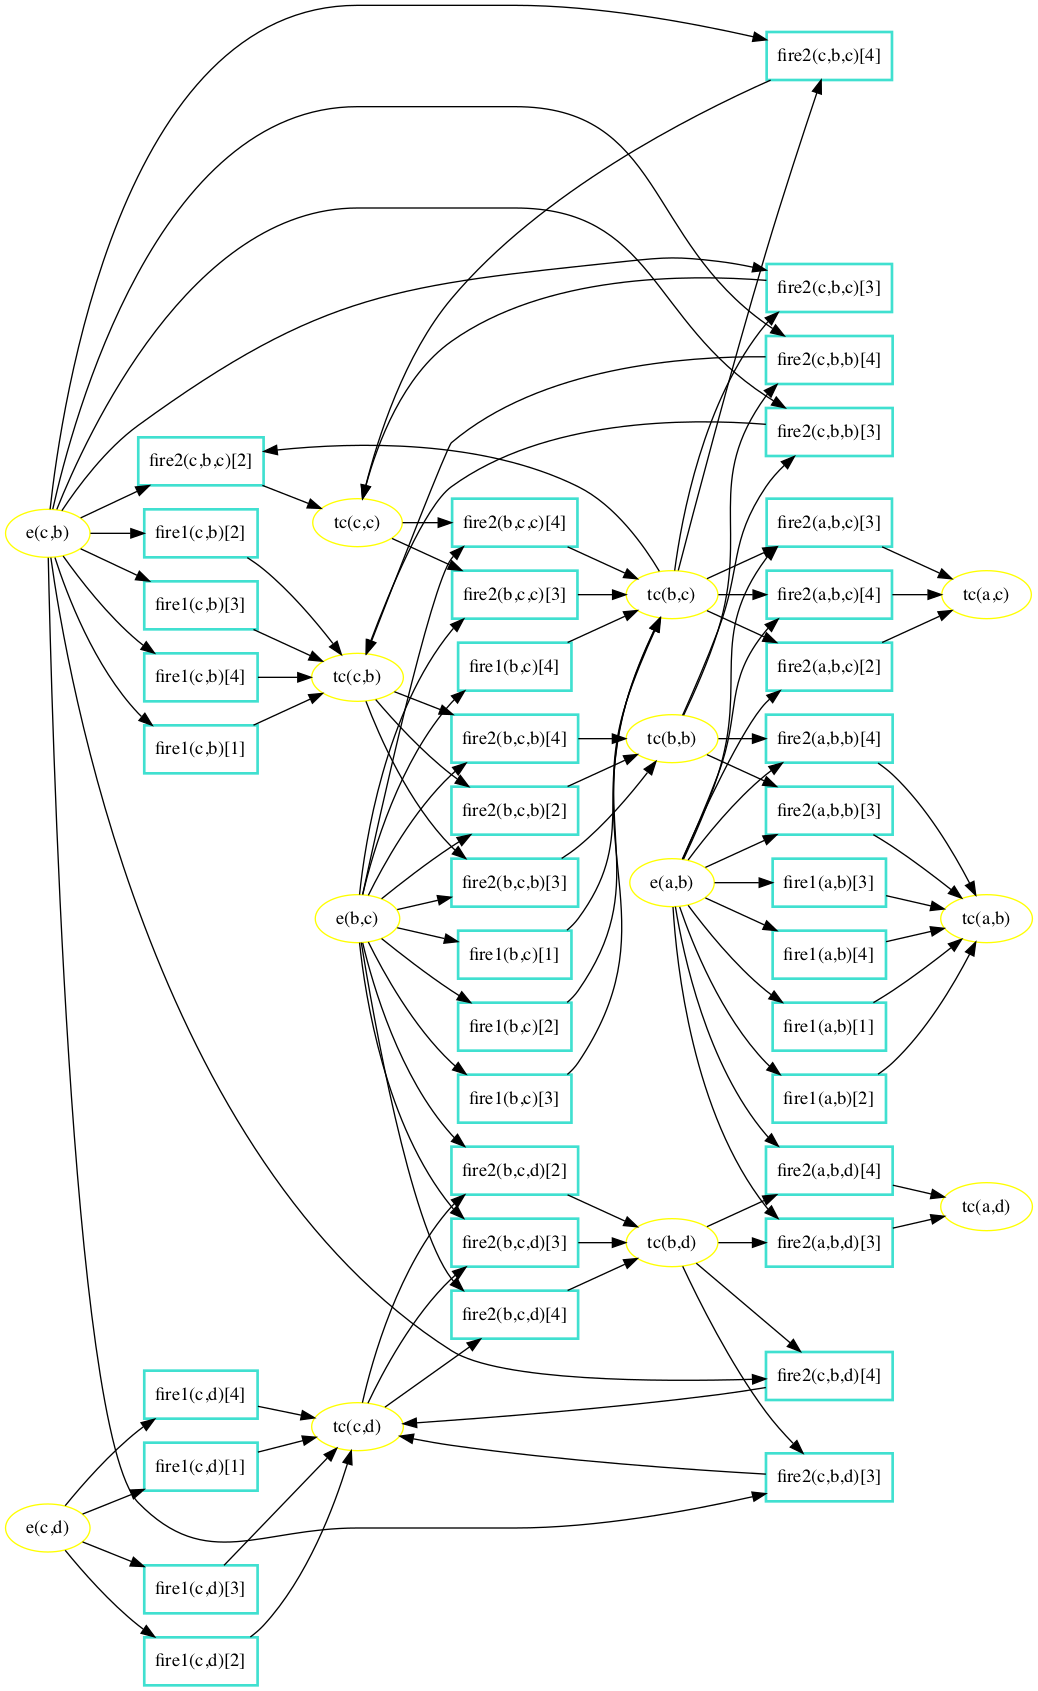

In [30]:
draw(g)

Above, we can see the provenance graph of the evaluation of the transitive closure query on the given graph instance. As we can see, the provenance of each of the output tc/2 facts can be clearly traced.

Since the total provenance graph can be quite big, we can build a "smarter" provenance graph where we only show the first instance of any rule-firings and collapse the future instances into it.

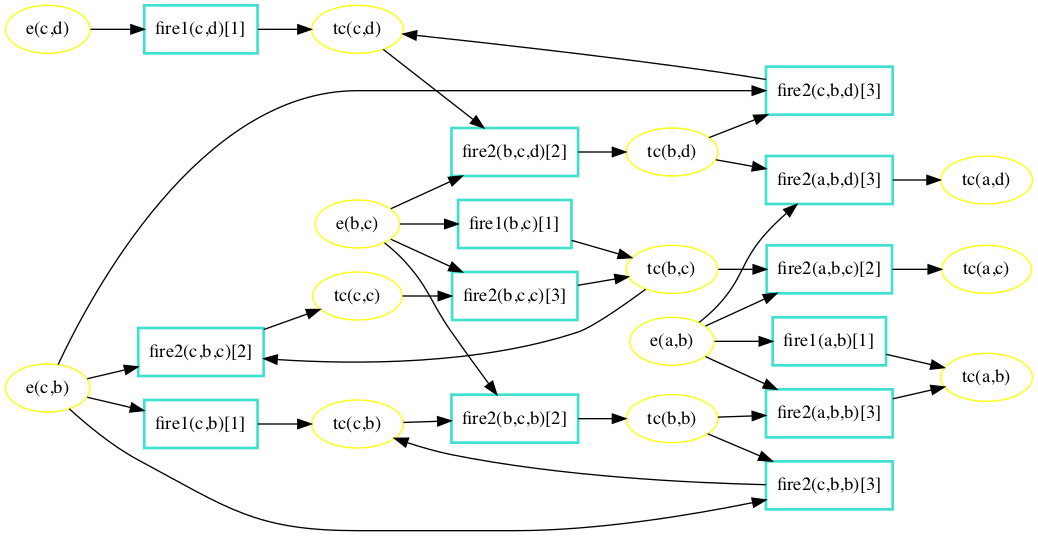

In [31]:
g = build_smart_prov_graph(dd_pw_rel_dfs['g_4'])
draw(g)

Similarly, we can extract the provenance for a specific output, by simply finding the ancestors of the relevant node in the provenance graph and analyze this.

Provenance for a particular derived fact:

In [32]:
node_ = 'tc(a,c)'
list(nx.ancestors(g, node_))

['fire2(a,b,c)',
 'fire1(b,c)',
 'tc(c,c)',
 'fire2(b,c,c)',
 'e(b,c)',
 'e(a,b)',
 'fire2(c,b,c)',
 'e(c,b)',
 'tc(b,c)']

In [33]:
g2 = g.copy()
g2.remove_nodes_from([n for n in g2.nodes if n not in list(nx.ancestors(g, node_)) + [node_]])
g2.nodes[node_]['color'] = 'red'

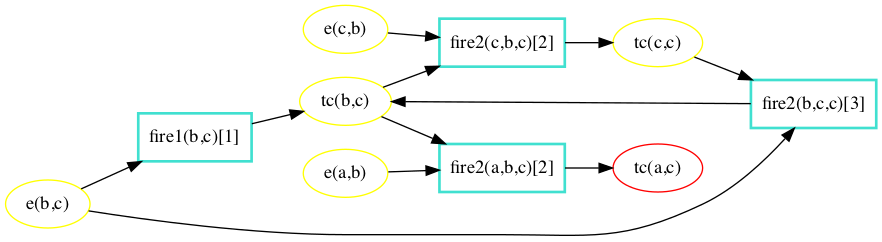

In [34]:
draw(g2)

#### Further Analysis using the rich provenance information

With the available provenance information, we can take the approach further and gain more insight into the query and its encoding.

Exporting the Provenance information as a set of Datalog Facts.

In [35]:
dd_output_facts = PWEExport.export_as_asp_facts(dd_pw_objs, attr_defs=fgs_md['attr_def'], include_pw_ids=False)

In [36]:
%%clingo -l dd_output_facts --donot-display_input
provGraph(X,L,Y) :- g(_,X,L,Y).
#show provGraph/3.

Output:


'Answer: 1\nprovGraph(fire1(c,d),out,tc(c,d)) provGraph(fire1(c,b),out,tc(c,b)) provGraph(fire1(b,c),out,tc(b,c)) provGraph(fire1(a,b),out,tc(a,b)) provGraph(e(a,b),in,fire1(a,b)) provGraph(e(b,c),in,fire1(b,c)) provGraph(e(c,b),in,fire1(c,b)) provGraph(e(c,d),in,fire1(c,d)) provGraph(fire2(c,b,c),out,tc(c,c)) provGraph(fire2(a,b,c),out,tc(a,c)) provGraph(fire2(b,c,b),out,tc(b,b)) provGraph(fire2(b,c,d),out,tc(b,d)) provGraph(fire2(c,b,d),out,tc(c,d)) provGraph(fire2(a,b,d),out,tc(a,d)) provGraph(fire2(c,b,b),out,tc(c,b)) provGraph(fire2(a,b,b),out,tc(a,b)) provGraph(fire2(b,c,c),out,tc(b,c)) provGraph(tc(c,d),in,fire2(b,c,d)) provGraph(tc(c,b),in,fire2(b,c,b)) provGraph(tc(b,c),in,fire2(a,b,c)) provGraph(tc(b,c),in,fire2(c,b,c)) provGraph(tc(c,c),in,fire2(b,c,c)) provGraph(tc(b,b),in,fire2(a,b,b)) provGraph(tc(b,b),in,fire2(c,b,b)) provGraph(tc(b,d),in,fire2(a,b,d)) provGraph(tc(b,d),in,fire2(c,b,d)) provGraph(e(b,c),in,fire2(b,c,d)) provGraph(e(b,c),in,fire2(b,c,b)) provGraph(e(a,b),in,fire2(a,b,c)) provGraph(e(c,b),in,fire2(c,b,c)) provGraph(e(b,c),in,fire2(b,c,c)) provGraph(e(a,b),in,fire2(a,b,b)) provGraph(e(c,b),in,fire2(c,b,b)) provGraph(e(a,b),in,fire2(a,b,d)) provGraph(e(c,b),in,fire2(c,b,d))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.004s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.004s'

In [37]:
%%clingo -l dd_output_facts --donot-display_input
provView(Q, X, out, Q) :- g(_, X, out, Q).
provView(Q, X, L, Y) :- provView(Q,Y,_,_), g(_,X,L,Y).
#show provView/4.

Output:


'Answer: 1\nprovView(tc(c,d),fire1(c,d),out,tc(c,d)) provView(tc(c,b),fire1(c,b),out,tc(c,b)) provView(tc(b,c),fire1(b,c),out,tc(b,c)) provView(tc(a,b),fire1(a,b),out,tc(a,b)) provView(tc(c,c),fire2(c,b,c),out,tc(c,c)) provView(tc(a,c),fire2(a,b,c),out,tc(a,c)) provView(tc(b,b),fire2(b,c,b),out,tc(b,b)) provView(tc(b,d),fire2(b,c,d),out,tc(b,d)) provView(tc(c,d),fire2(c,b,d),out,tc(c,d)) provView(tc(a,d),fire2(a,b,d),out,tc(a,d)) provView(tc(c,b),fire2(c,b,b),out,tc(c,b)) provView(tc(a,b),fire2(a,b,b),out,tc(a,b)) provView(tc(b,c),fire2(b,c,c),out,tc(b,c)) provView(tc(c,d),e(c,d),in,fire1(c,d)) provView(tc(c,b),e(c,b),in,fire1(c,b)) provView(tc(b,c),e(b,c),in,fire1(b,c)) provView(tc(a,b),e(a,b),in,fire1(a,b)) provView(tc(c,c),tc(b,c),in,fire2(c,b,c)) provView(tc(c,c),e(c,b),in,fire2(c,b,c)) provView(tc(a,c),tc(b,c),in,fire2(a,b,c)) provView(tc(a,c),e(a,b),in,fire2(a,b,c)) provView(tc(b,b),tc(c,b),in,fire2(b,c,b)) provView(tc(b,b),e(b,c),in,fire2(b,c,b)) provView(tc(b,d),tc(c,d),in,fire2(b,c,d)) provView(tc(b,d),e(b,c),in,fire2(b,c,d)) provView(tc(c,d),tc(b,d),in,fire2(c,b,d)) provView(tc(c,d),e(c,b),in,fire2(c,b,d)) provView(tc(a,d),tc(b,d),in,fire2(a,b,d)) provView(tc(a,d),e(a,b),in,fire2(a,b,d)) provView(tc(c,b),tc(b,b),in,fire2(c,b,b)) provView(tc(c,b),e(c,b),in,fire2(c,b,b)) provView(tc(a,b),tc(b,b),in,fire2(a,b,b)) provView(tc(a,b),e(a,b),in,fire2(a,b,b)) provView(tc(b,c),tc(c,c),in,fire2(b,c,c)) provView(tc(b,c),e(b,c),in,fire2(b,c,c)) provView(tc(c,c),fire1(b,c),out,tc(b,c)) provView(tc(c,c),fire2(b,c,c),out,tc(b,c)) provView(tc(a,c),fire1(b,c),out,tc(b,c)) provView(tc(a,c),fire2(b,c,c),out,tc(b,c)) provView(tc(b,b),fire1(c,b),out,tc(c,b)) provView(tc(b,b),fire2(c,b,b),out,tc(c,b)) provView(tc(b,d),fire1(c,d),out,tc(c,d)) provView(tc(b,d),fire2(c,b,d),out,tc(c,d)) provView(tc(c,d),fire2(b,c,d),out,tc(b,d)) provView(tc(a,d),fire2(b,c,d),out,tc(b,d)) provView(tc(c,b),fire2(b,c,b),out,tc(b,b)) provView(tc(a,b),fire2(b,c,b),out,tc(b,b)) provView(tc(b,c),fire2(c,b,c),out,tc(c,c)) provView(tc(c,c),e(b,c),in,fire1(b,c)) provView(tc(c,c),tc(c,c),in,fire2(b,c,c)) provView(tc(c,c),e(b,c),in,fire2(b,c,c)) provView(tc(a,c),e(b,c),in,fire1(b,c)) provView(tc(a,c),tc(c,c),in,fire2(b,c,c)) provView(tc(a,c),e(b,c),in,fire2(b,c,c)) provView(tc(b,b),e(c,b),in,fire1(c,b)) provView(tc(b,b),tc(b,b),in,fire2(c,b,b)) provView(tc(b,b),e(c,b),in,fire2(c,b,b)) provView(tc(b,d),e(c,d),in,fire1(c,d)) provView(tc(b,d),tc(b,d),in,fire2(c,b,d)) provView(tc(b,d),e(c,b),in,fire2(c,b,d)) provView(tc(c,d),tc(c,d),in,fire2(b,c,d)) provView(tc(c,d),e(b,c),in,fire2(b,c,d)) provView(tc(a,d),tc(c,d),in,fire2(b,c,d)) provView(tc(a,d),e(b,c),in,fire2(b,c,d)) provView(tc(c,b),tc(c,b),in,fire2(b,c,b)) provView(tc(c,b),e(b,c),in,fire2(b,c,b)) provView(tc(a,b),tc(c,b),in,fire2(b,c,b)) provView(tc(a,b),e(b,c),in,fire2(b,c,b)) provView(tc(b,c),tc(b,c),in,fire2(c,b,c)) provView(tc(b,c),e(c,b),in,fire2(c,b,c)) provView(tc(a,c),fire2(c,b,c),out,tc(c,c)) provView(tc(a,d),fire1(c,d),out,tc(c,d)) provView(tc(a,d),fire2(c,b,d),out,tc(c,d)) provView(tc(a,b),fire1(c,b),out,tc(c,b)) provView(tc(a,b),fire2(c,b,b),out,tc(c,b)) provView(tc(a,c),tc(b,c),in,fire2(c,b,c)) provView(tc(a,c),e(c,b),in,fire2(c,b,c)) provView(tc(a,d),e(c,d),in,fire1(c,d)) provView(tc(a,d),tc(b,d),in,fire2(c,b,d)) provView(tc(a,d),e(c,b),in,fire2(c,b,d)) provView(tc(a,b),e(c,b),in,fire1(c,b)) provView(tc(a,b),tc(b,b),in,fire2(c,b,b)) provView(tc(a,b),e(c,b),in,fire2(c,b,b))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

We can use a simple Datalog query to find the provenance of a particular result. We've seen how to do this in Python, we can do the same in ASP itself as shown below:

In [38]:
%%clingo -l dd_output_facts --donot-display_input
% Q = tc(a,d)
provView(tc(a,d), X, out, tc(a,d)) :- g(_, X, out, tc(a,d)).
provView(tc(a,d), X, L, Y) :- provView(tc(a,d),Y,_,_), g(_,X,L,Y).
#show provView/4.

Output:


'Answer: 1\nprovView(tc(a,d),fire2(a,b,d),out,tc(a,d)) provView(tc(a,d),tc(b,d),in,fire2(a,b,d)) provView(tc(a,d),e(a,b),in,fire2(a,b,d)) provView(tc(a,d),fire2(b,c,d),out,tc(b,d)) provView(tc(a,d),tc(c,d),in,fire2(b,c,d)) provView(tc(a,d),e(b,c),in,fire2(b,c,d)) provView(tc(a,d),fire1(c,d),out,tc(c,d)) provView(tc(a,d),fire2(c,b,d),out,tc(c,d)) provView(tc(a,d),e(c,d),in,fire1(c,d)) provView(tc(a,d),tc(b,d),in,fire2(c,b,d)) provView(tc(a,d),e(c,b),in,fire2(c,b,d))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

A simple Datalog query to find the first time-step when a particular rule instance was fired.

In [39]:
%%clingo -l dd_output_facts --donot-display_input
len(F,LenF) :- newFiring(S,F), LenF=S.
#show len/2.

Output:


'Answer: 1\nlen(fire1(c,d),1) len(fire1(c,b),1) len(fire1(b,c),1) len(fire1(a,b),1) len(fire2(c,b,c),2) len(fire2(a,b,c),2) len(fire2(b,c,b),2) len(fire2(b,c,d),2) len(fire2(c,b,d),3) len(fire2(a,b,d),3) len(fire2(c,b,b),3) len(fire2(a,b,b),3) len(fire2(b,c,c),3)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.004s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.004s'

We can use a similar query to find the first time-step at which a certain output was first computed,

In [40]:
%%clingo -l dd_output_facts --donot-display_input
len(A,LenA) :- newAtom(S,A), LenA=S.
#show len/2.

Output:


'Answer: 1\nlen(tc(c,d),1) len(tc(c,b),1) len(tc(b,c),1) len(tc(a,b),1) len(tc(c,c),2) len(tc(a,c),2) len(tc(b,b),2) len(tc(b,d),2) len(tc(a,d),3)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.006s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.006s'

A simple query to find the number of outputs in the query evaluation.

In [41]:
%%clingo -l dd_output_facts --donot-display_input
derived(H) :- g(_,_,out, H).
derivedHeadCount(C) :- C = #count{H : derived(H)}.
#show derived/1.
#show derivedHeadCount/1.

Output:


'Answer: 1\nderived(tc(c,d)) derived(tc(c,b)) derived(tc(b,c)) derived(tc(a,b)) derived(tc(c,c)) derived(tc(a,c)) derived(tc(b,b)) derived(tc(b,d)) derived(tc(a,d)) derivedHeadCount(9)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

In [42]:
len(dd_pw_rel_dfs['tc_2'])

9

A similar query to find the total number of rule-firings during the query evaluation:

In [43]:
%%clingo -l dd_output_facts --donot-display_input
firing(F) :- g(_,F,out,_).
firingCount(C) :- C = #count{F : firing(F)}.
#show firing/1.
#show firingCount/1.

Output:


'Answer: 1\nfiring(fire1(c,d)) firing(fire1(c,b)) firing(fire1(b,c)) firing(fire1(a,b)) firing(fire2(c,b,c)) firing(fire2(a,b,c)) firing(fire2(b,c,b)) firing(fire2(b,c,d)) firing(fire2(c,b,d)) firing(fire2(a,b,d)) firing(fire2(c,b,b)) firing(fire2(a,b,b)) firing(fire2(b,c,c)) firingCount(13)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.004s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.004s'

In [44]:
len(dd_pw_rel_dfs['fire2_4']) + len(dd_pw_rel_dfs['fire1_3'])

38

We can use the provenance information to find the number of re-derivations for each of the facts. This is important to the efficiency of a query encoding.

In [45]:
%%clingo -l dd_output_facts --donot-display_input
len(A,LenA) :- newAtom(S,A), LenA=S.
reDerivation(S,F) :- g(S,F,out,A), len(A,LenA), LenA < S.
#show reDerivation/2.

Output:


'Answer: 1\nreDerivation(2,fire1(c,d)) reDerivation(2,fire1(c,b)) reDerivation(2,fire1(b,c)) reDerivation(2,fire1(a,b)) reDerivation(3,fire2(c,b,c)) reDerivation(3,fire2(a,b,c)) reDerivation(3,fire2(b,c,b)) reDerivation(3,fire2(b,c,d)) reDerivation(3,fire2(c,b,d)) reDerivation(3,fire2(c,b,b)) reDerivation(3,fire2(a,b,b)) reDerivation(3,fire2(b,c,c)) reDerivation(3,fire1(c,d)) reDerivation(3,fire1(c,b)) reDerivation(3,fire1(b,c)) reDerivation(3,fire1(a,b)) reDerivation(4,fire2(c,b,c)) reDerivation(4,fire2(a,b,c)) reDerivation(4,fire2(b,c,b)) reDerivation(4,fire2(b,c,d)) reDerivation(4,fire2(c,b,d)) reDerivation(4,fire2(a,b,d)) reDerivation(4,fire2(c,b,b)) reDerivation(4,fire2(a,b,b)) reDerivation(4,fire2(b,c,c)) reDerivation(4,fire1(c,d)) reDerivation(4,fire1(c,b)) reDerivation(4,fire1(b,c)) reDerivation(4,fire1(a,b))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

In [46]:
%%clingo -l dd_output_facts --donot-display_input -s rederiv_out
len(A,LenA) :- newAtom(S,A), LenA=S.
reDerivation(S,F) :- g(S,F,out,A), len(A,LenA), LenA < S.
reDerivCount(S,C) :- C = #count{F : reDerivation(S,F)}, reDerivation(S,_).
#show reDerivCount/2.

Output:


'Answer: 1\nreDerivCount(2,4) reDerivCount(3,12) reDerivCount(4,13)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

In [47]:
rederiv_pw_rel_dfs, _, _ = load_worlds(rederiv_out, None)

Number of Models: 1


In [48]:
rederiv_pw_rel_dfs['reDerivCount_2']['x2'] = pd.to_numeric(rederiv_pw_rel_dfs['reDerivCount_2']['x2'])

In [49]:
sum(rederiv_pw_rel_dfs['reDerivCount_2']['x2'])

29

As we can see, there were a total of 29 rederivations during the query evaluation.

We can also compute this directly in ASP as follows:

In [50]:
%%clingo -l dd_output_facts --donot-display_input
len(A,LenA) :- newAtom(S,A), LenA=S.
reDerivation(S,F) :- g(S,F,out,A), len(A,LenA), LenA < S.
reDerivCount(S,C) :- C = #count{F : reDerivation(S,F)}, reDerivation(S,_).
reDerivTotal(T) :- T = #sum{C : reDerivCount(S,C)}.
#show reDerivTotal/1.

Output:


'Answer: 1\nreDerivTotal(29)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'